In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import simulation as sim
import analysis
from scipy.optimize import curve_fit

In [3]:
# Tijmen

beta_values = np.arange(0.5, 3, 0.1)

for beta_value in beta_values:
    analysis.try_gather_data_and_plot(state=sim.ordered_state(width=6),beta=beta_value,k=0,n=1,measurements=3000)

In [4]:
# Ties

beta_values = np.arange(3, 6, 0.1)

for beta_value in beta_values:
    analysis.try_gather_data_and_plot(state=sim.ordered_state(width=6),beta=beta_value,k=0,n=1,measurements=3000)

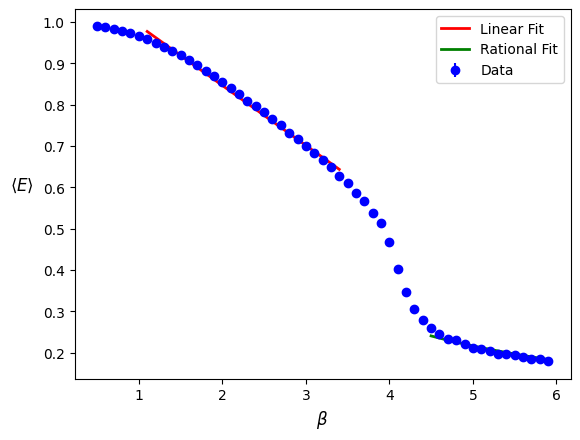

In [27]:
all_actions = []

def jackknife_batch_estimate(data,observable,k):
    '''Devide data into k batches and apply the function observable to each
    collection of all but one batches. Returns the mean and corrected
    standard error.'''
    batches = np.reshape(data,(k,-1))
    values = [observable(np.delete(batches,i,0).flatten()) for i in range(k)]
    return np.mean(values), np.sqrt(k-1)*np.std(values)

beta1s = np.arange(0.5, 3, 0.1)
with h5py.File('data/w6_actionbetas_part1.hdf5','r') as f:
    for beta1 in beta1s:
        actions = f[f"actions_w6_b{np.round(beta1,decimals=2)}"][()]
        all_actions.append(actions)

beta2s = np.arange(3, 6, 0.1)
with h5py.File('data/w6_actionbetas_part2.hdf5','r') as f:
    for beta2 in beta2s:
        actions = f[f"actions_w6_b{np.round(beta2,decimals=2)}"][()]
        all_actions.append(actions)

betas = np.concatenate([beta1s, beta2s])
all_actions = [np.array(actions) for actions in all_actions]  # Ensure arrays
mean_actions = []
std_devs = []

num_batches = 50

for actions in all_actions:
    mean_action, std_dev = jackknife_batch_estimate(actions, lambda x: np.mean(x), num_batches)
    mean_actions.append(mean_action)
    std_devs.append(std_dev)

def linear_fit(beta, a, b):
    return a + b * beta

def rational_fit(beta, c):
    return 1/(c * beta)

linear_mask = (betas > 1) & (betas < 3.5)
beta_linear = betas[linear_mask]
mean_linear = np.array(mean_actions)[linear_mask]

linear_params, linear_cov = curve_fit(linear_fit, beta_linear, mean_linear)

rational_mask = betas > 4.5
beta_rational = betas[rational_mask]
mean_rational = np.array(mean_actions)[rational_mask]

rational_params, rational_cov = curve_fit(rational_fit, beta_rational, mean_rational)

linear_fit_vals = linear_fit(beta_linear, *linear_params)
rational_fit_vals = rational_fit(beta_rational, *rational_params)

plt.errorbar(betas, mean_actions, std_devs, fmt='o', label='Data', color='blue')
plt.plot(beta_linear, linear_fit_vals, label='Linear Fit', color='red', linewidth=2)
plt.plot(beta_rational, rational_fit_vals, label='Rational Fit', color='green', linewidth=2)

plt.xlabel(r'$\beta$', fontsize=12)
plt.ylabel(r'$\langle E \rangle$', rotation=0, labelpad=15, fontsize=12)
plt.legend()
plt.show()